#### Objective: How to better beamform
#### Metrics: Time Performance; Data Rate; Versatality in different cases
#### 

#### Libraries


In [15]:
# helper|
from functools import wraps
import time

# math
import numpy as np
import scipy.io
import scipy as sp
import math
import cvxpy as cp

#plotting
import matplotlib.pyplot as plt
import time


#### Functions

In [16]:
def generate_channel_coeffs(Nx = 2,y_loc = 5,no_of_samples = 1):
    
    ## No of IRS Elements
    Ny = Nx
    
    ## Total Number of IRS Elements 
    N = Nx * Ny # Total number of IRS elements
    Nt = 1  # Number of antennas at the transmitter

    # Maximum power
    max_power_dBm = 10 # dB in milli
    max_power_dB = max_power_dBm - 30 # Power in dB
    max_power_vec = 10**(max_power_dB/10) # Power in Watts
    Bandwidth = 1e6 # Bandwidth
    noise_power_dBm =  -174 + 10*np.log10(Bandwidth) + 10 # +10 for noise figure
    noise_power_dB = noise_power_dBm - 30 # 
    noise_var = 10**(noise_power_dB/10)

    ## Rician parameters
    K_rf = 10

    ## Antenna gains in dB
    AP_ant_gain_dB   =  0
    user_ant_gain_dB = 0
    IRS_ant_gain_dB  = 2

    fc = 2.4 *(10**9)    #carrier frequency
    lambd = ( 3 * 10^8 )/ fc # in meters
    d_bs = lambd/2       # Spacing between BS antenna elements in meters
    penetration_loss_dB =  20

    # cosine  of angle for different antennaes 
    cos_an = np.cos( np.pi/10  )
    ph_inx = np.arange(Nt-1)

    # Path loss coefficients, Path loss in db
    path_loss_dB = lambda d,eta : 10 * np.log10( 1 / 1e3  / d**(eta) )
    eta_dL = 3.6 # Direct
    eta_irs = 2.2 # with IRS

    d_irs = lambd/4 # Distance between IRS elements
    irs_ele_loc = np.arange(Nx)*d_irs; # Location of IRS Elements
    coord_X,coord_Y = np.array(np.meshgrid(np.arange(Nx),np.arange(Nx))).T.reshape(-1,N)
    X,Y = np.meshgrid(irs_ele_loc,irs_ele_loc)
    loc = X.flatten() + 1j*Y.flatten()
    
    ## Correlation Matrix Spatial
    R = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            R[i][j] = np.sinc(2*(np.abs(loc[i]-loc[j]))/lambd)
            
    sqrtR = sp.linalg.sqrtm(R)

    N_vec = np.arange(N) ### Vector with elements from 0 to N-1
    # Coordinates of IRS Elements
    u_irs = np.vstack((np.zeros(N),np.mod(N_vec-1,Nx),np.floor((N_vec-1)/Nx)))

    ### X,Y,Z Location of Base Station
    x,y,z =  0 ,-10, 0 
    bs_loc = np.array([x,y,z])
    r = np.sqrt(x*x + y*y + z*z)
    azimuth = np.arctan2(y,x)
    elevation = np.arccos(z/r)
    d_BS_IRS = r  ### I.R.S. is at origin Distance of  BS to IRS
    psi_irs = azimuth
    the_irs = elevation
    psi_bs = np.pi - np.abs(azimuth)
    the_bs = elevation

    ### X,Y,Z Location of User
    x,y,z =  0 ,y_loc, -2 
    user_loc = np.array([x,y,z])
    r = np.sqrt(x*x + y*y + z*z)
    azimuth = np.arctan2(y,x)
    elevation = np.arccos(z/r)
    psi_irs_u = azimuth
    the_irs_u = elevation
    d_IRS_user = r   # Since I.R.S. is at origin
    d_BS_user = np.linalg.norm(bs_loc - user_loc) # Distance between Base Station and User

    ### k vector X,Y,Z from Azimuthal and Elevation
    k_vec = lambda azi_an, ele_an : np.array(  [ np.cos(azi_an)*np.cos(ele_an), np.sin(azi_an)*np.cos(ele_an),np.sin(ele_an)])
    # What is this a_irs?
    a_irs = lambda azi_an, ele_an : np.transpose(np.exp( 1j * 2 * np.pi * (d_irs/lambd) * k_vec(azi_an, ele_an).reshape(1,3) @ u_irs ))
    # x y z locations for BS antenas
    u_bs = np.vstack( [ bs_loc[0] +  d_bs * np.arange(Nt) ,  bs_loc[1] * np.ones((1,Nt))   , bs_loc[2] * np.ones((1,Nt))  ]  )
    a_bs = lambda azi_an, ele_an :  np.transpose(np.exp( 1j * 2 * np.pi * (d_bs/lambd) * k_vec(azi_an, ele_an).reshape(1,3) @ u_bs ))    
   
    max_power = max_power_vec
    mu_hd_dB = AP_ant_gain_dB + user_ant_gain_dB + path_loss_dB(d_BS_user,eta_dL) - penetration_loss_dB
    mu_hd = 10**(mu_hd_dB/10) 
    ### Direct Link
    hd_link = np.sqrt(mu_hd/2) * ( np.random.randn(Nt,no_of_samples) + 1j *  np.random.randn(Nt,no_of_samples)  ) 
    #hd_norm_vec  =   np.sqrt(np.sum( np.abs(hd_link)**2  ,1))
    
    
    mu_G_dB =  AP_ant_gain_dB + IRS_ant_gain_dB + path_loss_dB(d_BS_IRS,eta_irs) 
    mu_G = 10**(mu_G_dB/10)

    ### BS To IRS
    G_LOS =  np.sqrt(K_rf /(K_rf+1)) * np.sqrt(mu_G) *  a_bs(psi_bs,the_bs)  @ a_irs(psi_irs, the_irs).T 
    G_NLOS = (np.sqrt(1/(K_rf + 1)) * np.sqrt(mu_G/2)) *(sqrtR @ ( np.random.randn(no_of_samples,N,Nt) + 1j * np.random.randn(no_of_samples,N,Nt))).reshape(N,Nt,no_of_samples) 
    G_link = np.transpose(G_LOS).reshape((N,Nt,1)) + G_NLOS
    
    
    mu_hr_dB =   IRS_ant_gain_dB + user_ant_gain_dB + path_loss_dB(d_IRS_user,eta_irs) - penetration_loss_dB;
    mu_hr = 10**(mu_hr_dB/10);
    ### IRS To User 
    hr_LOS = np.sqrt(mu_hr * K_rf  / (K_rf +1)) * a_irs(psi_irs_u, the_irs_u)    
    hr_NLOS = np.sqrt(mu_hr/2/(K_rf +1)) *( (sqrtR) @ ( np.random.randn(N,no_of_samples) + 1j * np.random.randn(N,no_of_samples))).reshape(N,no_of_samples) 
    hr_link = hr_LOS  +  hr_NLOS
    return np.concatenate([hd_link,G_link.reshape(N,no_of_samples)*hr_link])


In [17]:
generate_channel_coeffs(10,-5,500).T.shape

(500, 101)

#### How to generate across frequencies ?

In [18]:
# get IRS configuration
def get_config(method = None,M=2):
    if method == None:
        return np.exp(2j*np.random.randint(M,size=N_e)*np.pi/M)

In [19]:
# calculate the datarate for the given configuration of IRS
def calculate_datarate(H,x):
    indi=np.log2(1+(np.square(np.abs(H)))*abs(np.square(x).sum())/10**-14)
    return np.sum(indi)*10**6

In [177]:
# vector method
def angle_mapper(rads,M):
    lis = (np.arange(M)/M)*2*np.pi
    for i in range(len(lis)-1):
        if lis[i]<rads and lis[i+1]>rads:
            if (lis[i] - rads) < (lis[i+1] - rads):
                return lis[i]
            else:
                return lis[i+1]
    return lis[i+1]
vec_angle_mapper = np.vectorize(angle_mapper)
def return_coefficients(h_,opt,M=2):
    rads = np.angle(opt/h_)
    
    rads[rads <  0] += np.pi * 2
    angles = np.zeros(len(h_))

    for i in range(len(rads)-1):
        angles[i+1] = angle_mapper(rads[i],M) 
    angles[0] = 0
    return np.exp(2j*angles*np.pi/M)

def vector_heuristic(h,M=2):
    h_ = h.sum(axis=0)
    idx = np.argmax(np.abs(h_))

    return return_coefficients(h_,h_[idx],M)

In [163]:
print(np.angle(-0.38428853/0.92321304))
return_coefficients(np.array([0+1.1j]),np.ones(1),4)

3.141592653589793
[4.71238898]
4.71238898038469 [0.         1.57079633 3.14159265 4.71238898]
[0.         4.71238898]


array([1.        +0.j        , 0.43656614+0.89967217j])

In [21]:
# Greedy approach
def return_greedy_estimate(estimation,N_regions=100,M=2):
    estimation_sum = estimation.sum(axis=0)
    opt = np.exp(2j*np.asarray(range(M))*np.pi/M)
    angles = np.ones((estimation_sum.shape[0],N_regions)).astype(complex)
    for i in range(len(opt)):
        angles[:,i] = return_coefficients(estimation_sum,opt[i],M)
    abso=np.abs(np.matmul(angles.T,estimation_sum.reshape((-1,1))))
    opt_angle=angles[:,np.where((angles[0,:]==1) &(abso==np.max(abso)))[0]][:,0].flatten()
    return opt_angle

In [90]:
def strongest_tap(est,n_strong,N_e,K,L,N_regions=100,M=2):
    time_h = np.fft.ifft(est,K,axis=0)[:L,:]
    strongest_tap = np.argsort(np.abs(time_h),axis=0)[-1*n_strong:,:].reshape(N_e,n_strong)
    top_time_h = np.zeros((n_strong,N_e),dtype=complex)
    for i in range(N_e):
        top_time_h[:,i] = time_h[strongest_tap[i],i]
    h = np.fft.fft(top_time_h,500,axis=0) # FFT 
    theta = vector_heuristic(h,M) # Try out different stats
    return theta

In [23]:
def calculate_cascaded(H,Theta):
    Theta = Theta.reshape((N_e+1,1))
    G = H @ Theta ## Final  Channel across different subcarriers
    return G    

In [24]:
def return_rate_strongest_tap(H,N_e,K,L,sig,M=2):
    Theta = strongest_tap(H,1,N_e+1,K,L,N_regions = 100,M = M)
#     est,n_strong,N_e,K,L,N_regions=100,M=2
    #Theta = vector_heuristic(H,M)
    G = calculate_cascaded(H,Theta)
    R = calculate_datarate(G,sig)
    return R/10**8

In [25]:
def return_rate_sca(H,N_e,K,L,sig):
    a_init =  np.real(H[:,0]+(H[:,1:]@np.random.uniform(-1,1,size=(N_e,1))).sum(axis=1))
    b_init = np.imag(H[:,0]+(H[:,1:]@np.random.uniform(-1,1,size=(N_e,1))).sum(axis=1))

    f = lambda a,b: a_init**2 + b_init**2 + 2*cp.multiply(a_init,(a-a_init )) +2*cp.multiply(b_init,(b-b_init )) 

    yn = cp.Variable(K)
    x = cp.Variable(N_e,complex = True)
    tau = 1
    sigma = 10**-20
    a = cp.Variable(K) 
    b = cp.Variable(K)
    objective = cp.sum(cp.log(1+yn))
    objective = cp.Maximize(objective)
    constraints = [cp.abs(x) <= 1,
                   a == cp.real(H[:,0]+cp.sum(cp.multiply(cp.reshape(x,(1,N_e)),H[:,1:]),axis=1)),
                   b == cp.imag(H[:,0]+cp.sum(cp.multiply(cp.reshape(x,(1,N_e)),H[:,1:]),axis=1)),
                   yn <= cp.real(f(a,b)),]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    thetas = np.ones(N_e)
    thetas[np.angle(x.value,deg= True)<0] = -1 
    ThetaSDP = np.concatenate([[1],thetas])
    G = calculate_cascaded(H,np.concatenate([[1],x.value]))
    G = calculate_cascaded(H,ThetaSDP)
    RSDP = calculate_datarate(G,sig)
    return RSDP/10**8    

#### Generate Coefficients

Over the Number of Elements

In [91]:
## Power Distribution over different subcarriers: 
K = 100
L = 20
n_iter = 10

N_xs = [8,10,12,14]
vector = np.zeros((4,n_iter,2))
sca = np.zeros((4,n_iter,2))
j = 0
for N_x in N_xs: 
    N_e = N_x**2
    for i in range(n_iter):
        H = generate_channel_coeffs(N_x,-5,K).T
        IRS_config = get_config()
        Direct = np.ones(1).astype(np.complex128)
        Theta = np.concatenate((Direct,IRS_config)).reshape((N_e+1,1))
        G = H @ Theta 
        P = np.random.dirichlet(np.ones(K),size=1)
        P_max = 10 ## Power Budget in mW
        ## Symbol to be sent of 1mW
        s = 1e-3 * P_max
        w = G.copy()/(np.linalg.norm(s)*np.linalg.norm(G)) # Precoding Vector
        sig  = w*s # Final Symbol Transmitted
        sig = sig * P.T
        t = time.process_time()
        R = return_rate_strongest_tap(H,N_e,K,L,sig)
        vector[j][i] = time.process_time()-t,R
        t = time.process_time()
        R = return_rate_sca(H,N_e,K,L,sig)
        sca[j][i] = time.process_time()-t,R
    print(j)
    j += 1

0
1
2
3


Over the Number of Subcarriers

In [ ]:
## Power Distribution over different subcarriers: 
K = 500
L = 20
n_iter = 10

K_s = [10,100,1000]
vector_sub = np.zeros((3,n_iter,2))
sca_sub = np.zeros((3,n_iter,2))
j = 0
for K in K_s: 
    N_x = 8
    N_e = N_x**2
    for i in range(n_iter):
        H = generate_channel_coeffs(N_x,-5,K).T
        IRS_config = get_config()
        Direct = np.ones(1).astype(np.complex128)
        Theta = np.concatenate((Direct,IRS_config)).reshape((N_e+1,1))
        G = H @ Theta 
        P = np.random.dirichlet(np.ones(K),size=1)
        P_max = 10 ## Power Budget in mW
        ## Symbol to be sent of 1mW
        s = 1e-3 * P_max
        w = G.copy()/(np.linalg.norm(s)*np.linalg.norm(G)) # Precoding Vector
        sig  = w*s # Final Symbol Transmitted
        sig = sig * P.T
        t = time.process_time()
        R = return_rate_strongest_tap(H,N_e,K,L,sig)
        vector_sub[j][i] = time.process_time()-t,R
        t = time.process_time()
        R = return_rate_sca(H,N_e,K,L,sig)
        sca_sub[j][i] = time.process_time()-t,R
    print(j)
    j += 1

Over the Location Of Users

In [97]:
## Power Distribution over different subcarriers: 
K = 500
L = 20
n_iter = 1

Locs = [-9,-7,-5,-3,-1]
vector_user = np.zeros((5,n_iter,2))

vector_user1 = np.zeros((5,n_iter,2))
vector_user2 = np.zeros((5,n_iter,2))

sca_user = np.zeros((5,n_iter,2))

j = 0
for loc in Locs: 
    N_x = 14
    N_e = N_x**2
    for i in range(n_iter):
        H = generate_channel_coeffs(N_x,loc,K).T
        IRS_config = get_config()
        Direct = np.ones(1).astype(np.complex128)
        Theta = np.concatenate((Direct,IRS_config)).reshape((N_e+1,1))
        G = H @ Theta 
        P = np.ones(1) #np.random.dirichlet(np.ones(K),size=1)
        P_max = 10 ## Power Budget in mW
        ## Symbol to be sent of 1mW
        s = 1e-3 * P_max
        #w = G.copy()/(np.linalg.norm(s)*np.linalg.norm(G)) # Precoding Vector
        sig  = w*s # Final Symbol Transmitted
        sig = sig * P.T
        t = time.process_time()
        R = return_rate_strongest_tap(H,N_e,K,L,sig,2)
        vector_user[j][i] = time.process_time()-t,R
        
        t = time.process_time()
        R = return_rate_sca(H,N_e,K,L,sig)
        sca_user[j][i] = time.process_time()-t,R
    print(j)
    j += 1

0
1
2
3
4


### Visualization

In [175]:
H = generate_channel_coeffs(8,-1,100).T

In [190]:
time_h = np.fft.ifft(H,K,axis=0)[:L,:]
strongest_tap = np.argsort(np.abs(time_h),axis=0)[-1*1:,:].reshape(65,1)
top_time_h = np.zeros((1,65),dtype=complex)
for i in range(65):
    top_time_h[:,i] = time_h[strongest_tap[i],i]
h = np.fft.fft(top_time_h,500,axis=0) # FFT 

theta = return_greedy_estimate(h,50,M=8) # Try out different stats


In [191]:
J

array([-5.93172940e-04+4.54198396e-04j,  1.47205843e-04+4.41148876e-04j,
        4.90984543e-04+3.10675485e-05j,  9.69829875e-05+4.66112313e-04j,
       -4.26856373e-04+1.35077490e-04j, -2.58583434e-04-4.08462930e-04j,
        3.39157783e-04-3.04592343e-04j,  3.23134789e-04+2.98955075e-04j,
       -2.48779870e-04+3.86386133e-04j, -4.36246552e-04-1.80568034e-04j,
       -3.24534234e-04+3.41762368e-04j, -4.12991459e-04-2.60856644e-04j,
        1.37119140e-04-4.48684649e-04j,  4.58724880e-04+1.12354993e-04j,
       -3.95579921e-05+4.63336783e-04j, -4.78395652e-04+5.23574413e-05j,
       -1.25181284e-04-4.77699011e-04j,  4.02264014e-04-1.67718862e-04j,
       -6.49016434e-05-4.81190826e-04j,  4.43883742e-04-1.55725911e-04j,
        2.37512259e-04+4.12310169e-04j, -3.74230196e-04+2.57502619e-04j,
       -4.03972181e-04-3.33249870e-04j,  2.74662142e-04-4.04977223e-04j,
        4.49276429e-04+2.15146056e-04j, -1.49605370e-04+4.88760011e-04j,
        4.00417747e-04+2.27884061e-04j, -1.94466999

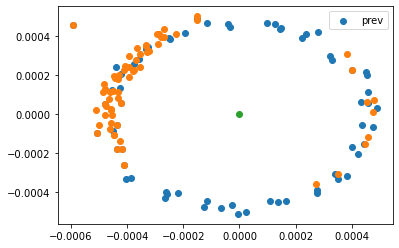

In [192]:
J = h.sum(axis = 0)
plt.scatter((J).real,(J).imag,label='prev')

plt.scatter((theta*J).real,(theta*J).imag)
plt.scatter(0,0)
plt.legend()

In [51]:
Theta.shape,H[0,:].shape

((65,), (65,))

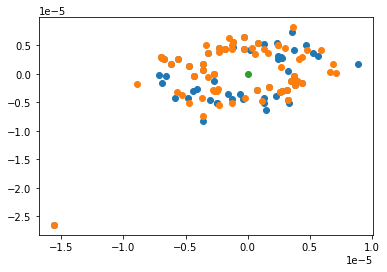

In [ ]:
plt.scatter(*zip(*sca.mean(axis = 1)),label="SCA_vectorinit",marker="x")
plt.scatter(*zip(*vector.mean(axis = 1)),label="Vector")
plt.legend()
for i, txt in enumerate(N_xs):
    plt.annotate(txt, (sca.mean(axis = 1)[i][0]+0.3, sca.mean(axis = 1)[i][1]))
    plt.annotate(txt, (vector.mean(axis = 1)[i][0]+0.001, vector.mean(axis = 1)[i][1]))
plt.title("Data Rate v/s Time Taken for different algorithm with varying number of IRS Elements")
plt.ylabel("Data Rate obtained")
plt.xlabel("Time taken for algorithm to run (log scale)")
plt.xscale("log")

In [ ]:
plt.scatter(*zip(*sca_sub.mean(axis = 1)),label="SCA_vectorinit",marker="x")
plt.scatter(*zip(*vector_sub.mean(axis = 1)),label="Vector")
plt.legend()
for i, txt in enumerate(K_s):
    plt.annotate(txt, (sca_sub.mean(axis = 1)[i][0]+0.03, sca_sub.mean(axis = 1)[i][1]))
    plt.annotate(txt, (vector_sub.mean(axis = 1)[i][0]+0.001, vector_sub.mean(axis = 1)[i][1]))
plt.title("Data Rate v/s Time Taken for different algorithm with varying number of Sub Carriers")
plt.ylabel("Data Rate obtained")
plt.xlabel("Time taken for algorithm to run (log scale)")
plt.xscale("log")

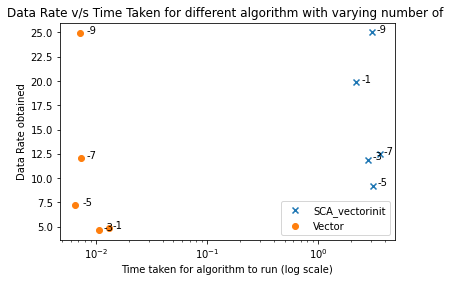

In [103]:
plt.scatter(*zip(*sca_user.mean(axis = 1)),label="SCA_vectorinit",marker="x")
plt.scatter(*zip(*vector_user.mean(axis = 1)),label="Vector")
plt.legend()
for i, txt in enumerate(Locs):
    plt.annotate(txt, (sca_user.mean(axis = 1)[i][0]+0.3, sca_user.mean(axis = 1)[i][1]))
    plt.annotate(txt, (vector_user.mean(axis = 1)[i][0]+0.001, vector_user.mean(axis = 1)[i][1]))
plt.title("Data Rate v/s Time Taken for different algorithm with varying number of ")
plt.ylabel("Data Rate obtained")
plt.xlabel("Time taken for algorithm to run (log scale)")
plt.xscale("log")

Text(0.5, 0, 'Location of User')

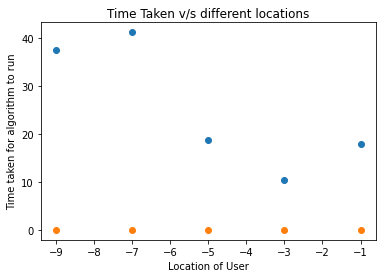

In [98]:
plt.scatter(Locs,sca_user[:,:,0].mean(1))
plt.scatter(Locs,vector_user[:,:,0].mean(1))
plt.title("Time Taken v/s different locations")
plt.ylabel("Time taken for algorithm to run")
plt.xlabel("Location of User")


Text(0.5, 0, 'Location of User')

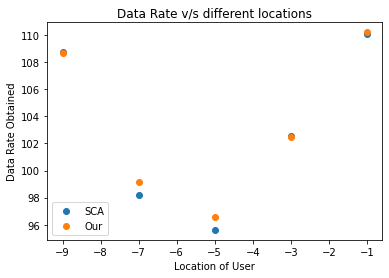

In [102]:
plt.scatter(Locs,sca_user[:,:,1].mean(1),label="SCA")
plt.scatter(Locs,vector_user[:,:,1].mean(1),label="Our")
# plt.scatter(Locs,vector_user1[:,:,1].mean(1),label="4")
# plt.scatter(Locs,vector_user2[:,:,1].mean(1),label="16")
plt.legend()
plt.title("Data Rate v/s different locations")
plt.ylabel("Data Rate Obtained")
plt.xlabel("Location of User")

.............................................................................................
\#### Method 1: SCA

#### Method 2: Vector Heuristic

#### Method 3: Benchmarking using Cross entropy

#### Visualisations

In [113]:
sca_user[:,:,0]

array([[5.77766224, 4.11035448, 6.27587723, 3.66205272, 6.06721597,
        5.91536721, 6.00767456, 2.83748819, 5.91314087, 4.44366056],
       [5.25493288, 5.42803469, 5.27880515, 5.21810706, 2.52439869,
        5.08205905, 5.24328195, 3.55735499, 5.20976769, 5.79886712],
       [5.33915148, 2.20726087, 5.14162837, 5.25724323, 3.40243798,
        5.11255186, 5.25691222, 3.92666702, 5.2728495 , 3.78886058],
       [4.49213975, 2.93134038, 1.96559866, 2.37919699, 1.97924718,
        5.4362585 , 3.60388143, 2.24590508, 2.26348392, 2.24502613],
       [1.70279897, 1.47392991, 1.7268783 , 1.92082867, 1.73157006,
        2.05473564, 1.75768751, 1.78373006, 1.66282134, 1.63778099]])